In [214]:
import os, re, sys
import ast

import matplotlib.pyplot as plt
from datetime import datetime as dt
import pandas as pd
import numpy as np 
import networkx as nx 
import kmeans

In [257]:
cols = ['budget','original_language', 'original_title', 'overview',
       'popularity',  'production_companies',
       'production_countries', 'release_date', 'revenue', 
       'spoken_languages',   'title',
       'vote_average', 'vote_count', 'genres'
       ]

In [258]:
df = pd.read_csv('movies_metadata.csv')[cols]
df = df.fillna(-999)

/var/folders/md/c9lgr11n7x1c0_tghtfh_kjr0000gn/T/ipykernel_17410/632078253.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('movies_metadata.csv')[cols]


**Helpers**

In [261]:
def get_genres(l): 
    try: 
        dicts = ast.literal_eval(l)
        return [x['name'] for x in dicts if 'name' in x]
    except: 
        pass

In [262]:
df['genre_list'] = df['genres'].apply(get_genres)
df['production_companies_list'] = df['production_companies'].apply(get_genres)
df['release_date_year'] = df['release_date'].str[:4]

# Create Graph

In [312]:
def first_gen(l): 
    try: 
        return l[:1].pop()
    except: 
        return 'Empty'

In [313]:
df['first_genre'] = df['genre_list'].apply(first_gen)

In [321]:
G = nx.Graph()
for i in range(len(df[:100])): 
    G.add_node(df['first_genre'][i])
    G.add_node(df['title'][i])
for i in range(len(df[:100])): 
    G.add_edge(df['first_genre'][i], df['title'][i])
    G.add_edge(df['release_date_year'][i], df['first_genre'][i])

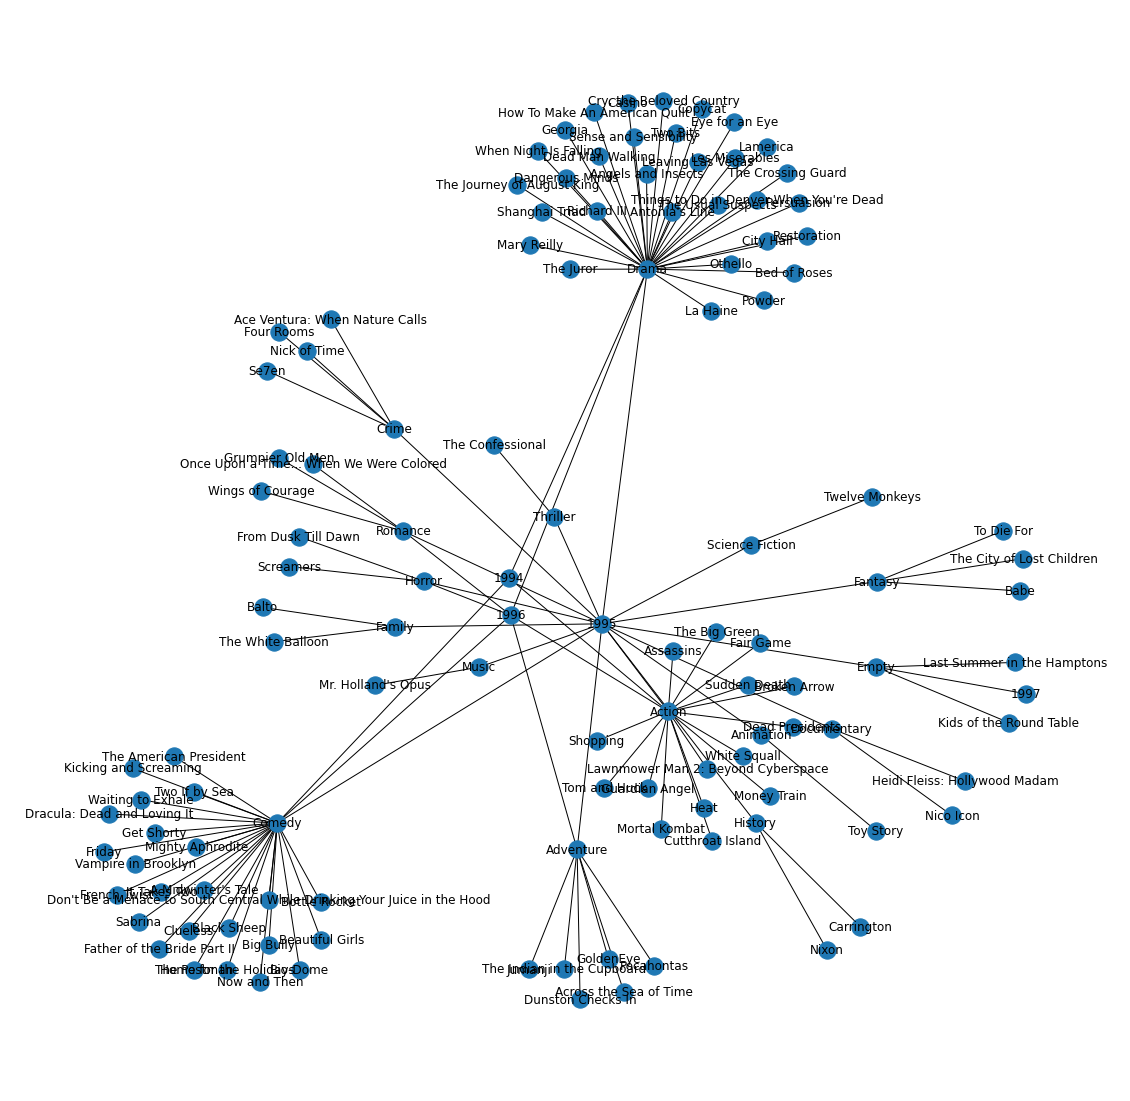

In [322]:
fig,axs = plt.subplots(1,1,figsize=(20,20))
nx.draw(G, with_labels=True,)